# Test set-up 
For an invertible matrix $X \in \mathbb{R}^{d\times d}$ and neural network approximator of the mapping  $X \rightarrow X^{-1}$ denoted by $f_{\theta}: \mathbb{R}^{d\times d} \rightarrow \mathbb{R}^{d\times d}$ parameterized by $\theta \in \Theta$, the ultimate goal is to minimize the risk or generalisation error 
$$ R(f) = \mathbb{E}[L(X,f_{\theta}(X))] $$

for some appropriate loss function $L(\cdot,\cdot)$. 

For a test set $(Y_i,X_i)_{i = 1}^n$, where $Y_i = X_i^{-1}$ we (currently) define the test error 
$$ \frac{1}{n} \sum_{i=1}^nL(X_i,f_{\theta}(X_i)), $$
where $$ L(X_i,f_{\theta}(X_i)) = \sum_{j,k}\left(X_if_{\theta}(X_i)-I\right)^2_{j,k}$$

#### Note that this is not necessarily the loss used in training

In [552]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [14, 7]
from collections import deque
import ConvNet
import MLP

## Generate test-set 
If no particular structure is called, matrices are generated as follows. 
\begin{align}
    & \mathbf{\lambda} \sim N(\mathbf{\mu},\Sigma), \qquad \Lambda := \text{diag}(\mathbf{\lambda}) \\
    & X = M\Lambda M^{-1},
\end{align}
where the elements of $M$ are sampled independently from a standard normal distribution.

In [567]:
class MatrixTestSet():
    #Generate a test set of N matrices of dimension d. 
    #Eigenvalues for each matrix are sampled from a d-variate normal distribution with mean vector mu and covariance matrix sigma
    #Resulting matrices are generated via similarity transformatins using random matrices. 
    def __init__(self,N,mu,sigma,d = 3,diagonal = False, triangular = False, similar = True):
        self.d = d
        D = np.random.multivariate_normal(mu,sigma,size = (N,1))
        D =  np.eye(D.shape[2])*D[:,np.newaxis] 
        if diagonal:
             self.X = torch.Tensor(D)
        elif triangular:
            #This is not finished. 
            #X = torch.Tensor(np.triu(np.random.randn(N,d,d)))
            #D = torch.Tensor(D)
            #X[:,].fill_diagonal_(D)
            None
        else:
            if similar: 
                M = np.random.randn(d,d)
            else: 
                M = np.random.randn(N,1,d,d)
            X = np.matmul(np.matmul(M,D),np.linalg.inv(M))
            self.X = torch.Tensor(X)
        
        self.Y = torch.linalg.inv(self.X) #Could maybe expand to other operations
        
    def get_error(self,model):
        id = torch.eye(self.d)
        return (torch.matmul(model(self.X),self.Y) - id).square().sum((2,3)).detach().numpy()
    def get_cond(self): 
        return torch.linalg.cond(self.X).detach().numpy()

## Properties of the test set generator 
Matrix generation is parameterized by mean vector $\bar{\mu}$ and covariance matrix $\Sigma$ associated with the normal distribution from which the eigenvalues of the matrices are drawn. What follows is an illustration of how the matrix properties vary with these parameters. 

Initially, we restrict ourselves to IID eigenvalues such that the mean vector is $[\mu, \cdots, \mu], \; \mu \in \mathbb{R}$ and covariance matrix $\Sigma = \sigma^2\mathbf{I}$.

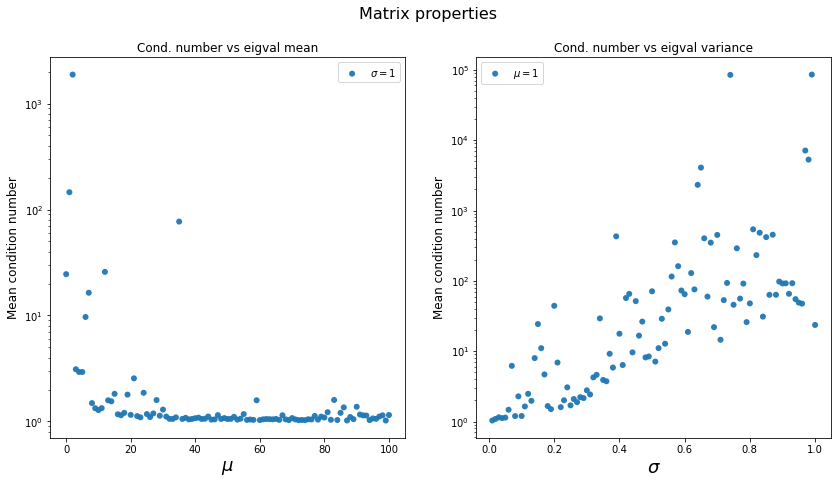

In [568]:
N = 1000
d = 3
#First, fix a covariance matrix and vary the mean 
sigma = np.eye(d)
cond = []
fig = plt.figure()
fig.suptitle("Matrix properties", fontsize=16)
for mu in range(101):
    mean = mu*np.ones((d))
    TestSet = MatrixTestSet(N,mean,sigma)
    cond.append(np.mean(TestSet.get_cond()))
ax = plt.subplot(121)
ax.set_title("Cond. number vs eigval mean", fontsize =12)
ax.scatter(np.linspace(0,100,101),cond, alpha=0.95, edgecolors='none', label='$\sigma = 1$')
ax.set_yscale('log')
ax.legend()
plt.xlabel('$\mu$', fontsize=18)
ylab = plt.ylabel('Mean condition number', fontsize=12)

#
mu = np.ones((d))
cond = []
for sigma in np.linspace(0.01,1,100):
    Sigma = sigma**2*np.eye(d)
    TestSet = MatrixTestSet(N,mu,Sigma)
    cond.append(np.mean(TestSet.get_cond()))
ax = plt.subplot(122)
ax.set_title('Cond. number vs eigval variance')
ax.scatter(np.linspace(0.01,1,100),cond, alpha=0.95, edgecolors='none', label='$\mu = 1$')
ax.set_yscale('log')
ax.legend()
#fig.title('Condition number vs eigval mean', fontsize=18)
plt.xlabel('$\sigma$', fontsize=18)
ylab = plt.ylabel('Mean condition number', fontsize=12)

    

### Conclusion
As a general note, eigenvalues close to zero implies that matrices are near-singular and the condition number is significantly increased. To have well-conditioned matrices, we should choose $\sigma<< \mu$

## Model performance on test set
First, we load our model(s) of choice:

In [584]:
model1 = MLP.MLP()
model2 = ConvNet.ConvNet()
model1.load_state_dict(torch.load("MLP_mu1sigma02_similar.pt"))
model2.load_state_dict(torch.load("CNN_mu1sigma02_similar.pt"))
input_independent_model = ConvNet.ConvNet()
input_independent_model.load_state_dict(torch.load("CNN_Input_Independent.pt"))
models = [input_independent_model,model1,model2]
handles = ['Input independent model',"MLP", "CNN"]

In [575]:
# Test set parameters. Initially, we set this to same as the training set. 
N = 1000
d = 3
mu = 1*np.ones((d))
sigma = 0.2**2*np.eye(d)

tensor([[[ 1.1564e+00,  9.3783e-04, -1.1846e-02],
         [ 1.3235e-02,  1.1657e+00, -7.3850e-03],
         [-2.9427e-02, -1.7974e-02,  1.1896e+00]]], grad_fn=<SelectBackward0>)


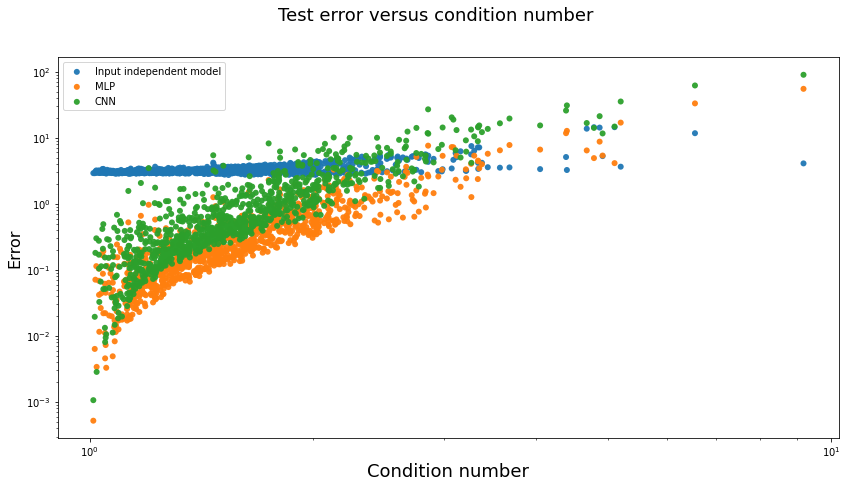

In [586]:
# Lets visualize the test errors 
TestSet = MatrixTestSet(N,mu,sigma)
cond = TestSet.get_cond()
fig = plt.figure()
ax = plt.gca()

for model in models:
    errors = TestSet.get_error(model)
    plt.scatter(cond,errors, alpha=0.95, edgecolors='none')# label = 'Model')

ax.set_yscale('log')
ax.set_xscale('log')
fig.suptitle('Test error versus condition number', fontsize=18)
plt.xlabel('Condition number', fontsize=18)
ylab = plt.ylabel('Error', fontsize=16)
ax.legend(handles)

## Model performance when varying test set parameters


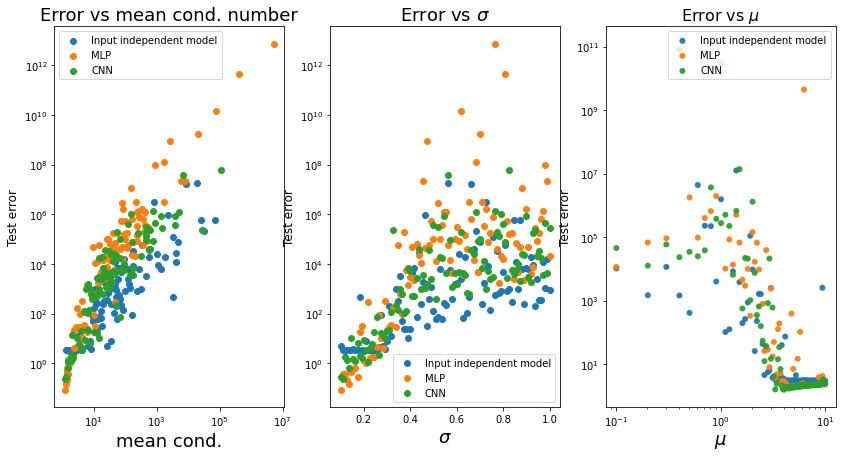

In [592]:
#This is not very pretty :) 
for model in models:
    mu = 1*np.ones((d))
    cond = []
    error = []
    for sigma in np.linspace(0.1,1,100):
        Sigma = sigma**2*np.eye(d)
        TestSet = MatrixTestSet(N,mu,Sigma)
        cond.append(np.mean(TestSet.get_cond()))
        error.append(TestSet.get_error(model).mean())

    ax = plt.subplot(131)
    ax.set_title('Error vs mean cond. number', fontsize = 18)
    ax.scatter(cond,error, label='$\mu = 1$')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend(handles)
    plt.xlabel('mean cond.', fontsize=18)
    ylab = plt.ylabel('Test error', fontsize=12)
    ax = plt.subplot(132)
    ax.set_title('Error vs $\sigma$', fontsize = 18)
    ax.scatter(np.linspace(0.1,1,100),error, label='$\mu = 1$')
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.legend(handles)
    plt.xlabel('$\sigma$', fontsize=18)
    ylab = plt.ylabel('Test error', fontsize=12)

    error = []
    sigma = np.eye(d)
    for mu in np.linspace(0,10,100):
        mean = mu*np.ones((d))
        TestSet = MatrixTestSet(N,mean,sigma)
        error.append(np.mean(TestSet.get_error(model)))
    ax = plt.subplot(133)
    ax.set_title("Error vs $\mu$", fontsize =16)
    ax.scatter(np.linspace(0,10,100),error, alpha=0.95, edgecolors='none', label='$\sigma = 1$')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend(handles)
    plt.xlabel('$\mu$', fontsize=18)
    ylab = plt.ylabel('Test error', fontsize=12)